# Khai báo thư viện cần thiết


In [8]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import pickle
import os
import time
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Extract features

In [52]:
def extract_features(path = 'data'):
    data = [[[0, 255, 0]], [1]]
    for folder in os.listdir(path):
        for file in os.listdir(os.path.join(path, folder)):
            if file.endswith('.jpg'):
                pathFile = os.path.join(path, folder, file)
                image = cv.imread(pathFile, 1)
                features = image.reshape(-1, 3)
                label = file.split('-')[1][0]
                data[0] = np.append(data[0], features, axis=0)
                data[1] += [label for _ in range(features.shape[0])]

    coefficients = np.array([[1] for _ in range(len(data[0]))])
    data[0] = np.append(data[0], coefficients, axis=1)
    
    return data

In [53]:
def save_data(data, name):
    with open(name + '.pickle', 'wb') as f:
        pickle.dump(data, f)

In [54]:
data = extract_features('data')
save_data(data, 'data')

# Train model


In [55]:
with open('data.pickle', 'rb') as f:
  data = pickle.load(f)

In [56]:
clf = LogisticRegression(random_state=0)

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(data[0],data[1], random_state=42)

In [58]:
print(clf.fit(X_train, Y_train))
print(clf.score(X_test, Y_test))

LogisticRegression(random_state=0)
1.0


In [59]:
df = pd.DataFrame()

In [60]:
df['pixcell'] = list(map(str, data[0]))
df['labels'] = list(map(int, data[1]))

In [61]:
df = df.drop_duplicates(subset='pixcell')

In [62]:
df.value_counts(subset='labels')

labels
0    352998
1       984
dtype: int64

In [63]:
clf.coef_

array([[-1.52987432e-01,  3.65921136e-01, -2.21554862e-01,
         7.31785231e-06]])

In [64]:
with open('model.pickle', 'wb') as f:
  pickle.dump(clf, f)

# Remove background


In [9]:
def load_model(file='model.pickle'):
    with open(file, 'rb') as f:
        model = pickle.load(f)

    return model.coef_[0]

In [26]:
def remove_green(img, coef, bg):

    newImg = img.copy()
    if img.shape != bg.shape:
        bg = cv.resize(bg, img.shape[-2::-1])

    w3, w2, w1, w0 = coef

    B, G, R = cv.split(img)
    inter = np.ones(R.shape)

    mask = w3 * B + w2 * G + w1 * R + w0 * inter

    mask = 1 / (1 + 1/np.exp(mask))  

    threhold = 0.999999  
    newImg[mask > threhold] = [0, 0, 0]
    bg[mask < threhold] = [0, 0, 0]

    return newImg + bg

# Xử lý và show kết quả


In [11]:
def process_video(path, bg):

    cap = cv.VideoCapture(path)
    frame_rate = 10
    prev = 0
    bg = cv.cvtColor(bg, cv.COLOR_BGR2RGB)
    coef = load_model()

    while (cap.isOpened()):
        time_elapsed = time.time() - prev
        ret, frame = cap.read()
        if float(time_elapsed) > 1./frame_rate:
            prev = time.time()

            frame = cv.GaussianBlur(frame, (5, 5), 0,9)
            
            processed_frame = remove_green(frame, coef, bg)
            resized_frame = cv.resize(processed_frame,(640,450),fx=0,fy=0, interpolation = cv.INTER_CUBIC)

            cv.imshow('frame', resized_frame)
        
            if cv.waitKey(1) & 0xFF == ord('q'):
                break

    cap.release()
    cv.waitKey(5)
    cv.destroyAllWindows()

In [12]:
def process_image(fg, bg):

    coef = load_model()

    bg = cv.imread(bg)
    bg = cv.cvtColor(bg, cv.COLOR_BGR2RGB)

    fg = cv.imread(fg)
    fg = cv.cvtColor(fg, cv.COLOR_BGR2RGB)
    newimg = remove_green(fg, coef, bg)
    
    return fg, bg, newimg


In [13]:
def read_img(path):
  img = cv.imread(path)
  img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  return img

In [14]:
def show_image(img, bg, newimg, n=3):
    f = plt.figure(figsize=(20,20))
   
    f.add_subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Foreground')

    f.add_subplot(1, 3, 2)
    plt.imshow(bg)
    plt.title('Background')

    f.add_subplot(1, 3, 3)
    plt.imshow(newimg)
    plt.title('Result')

    plt.show(block=True)
    

In [15]:
def save_image(img, name):
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    cv.imwrite('./output/' + name, img)


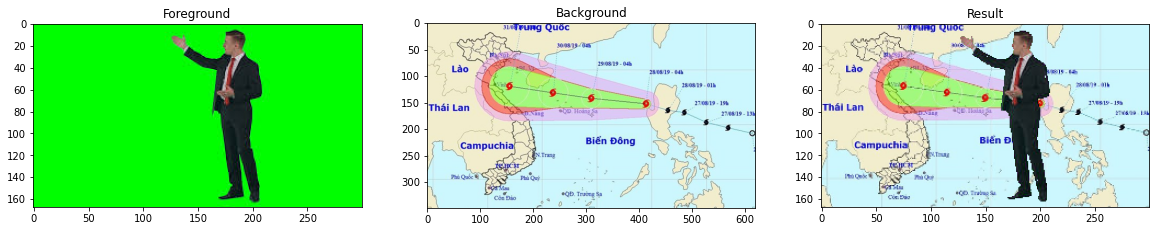

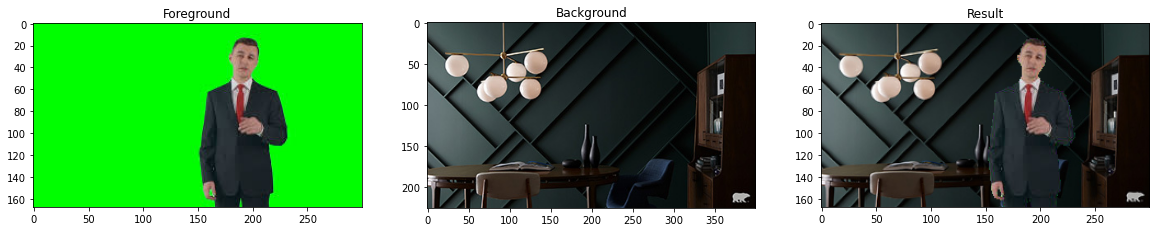

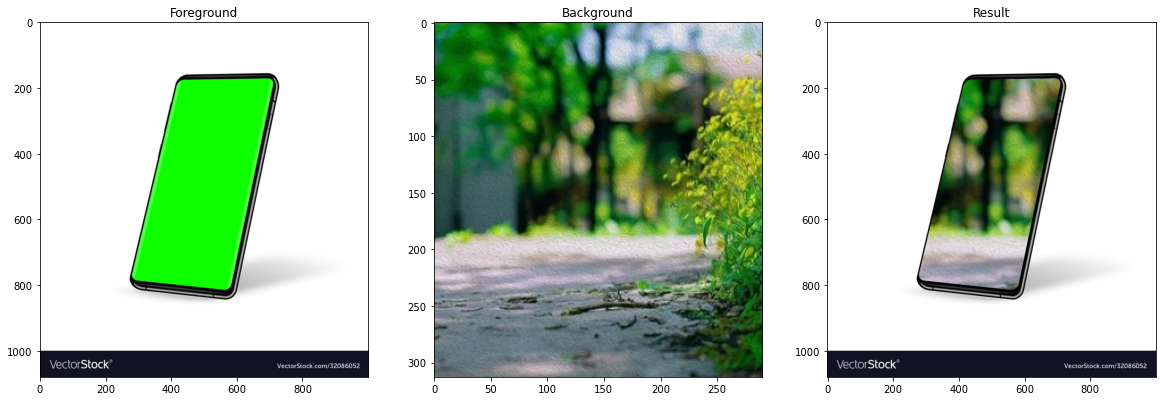

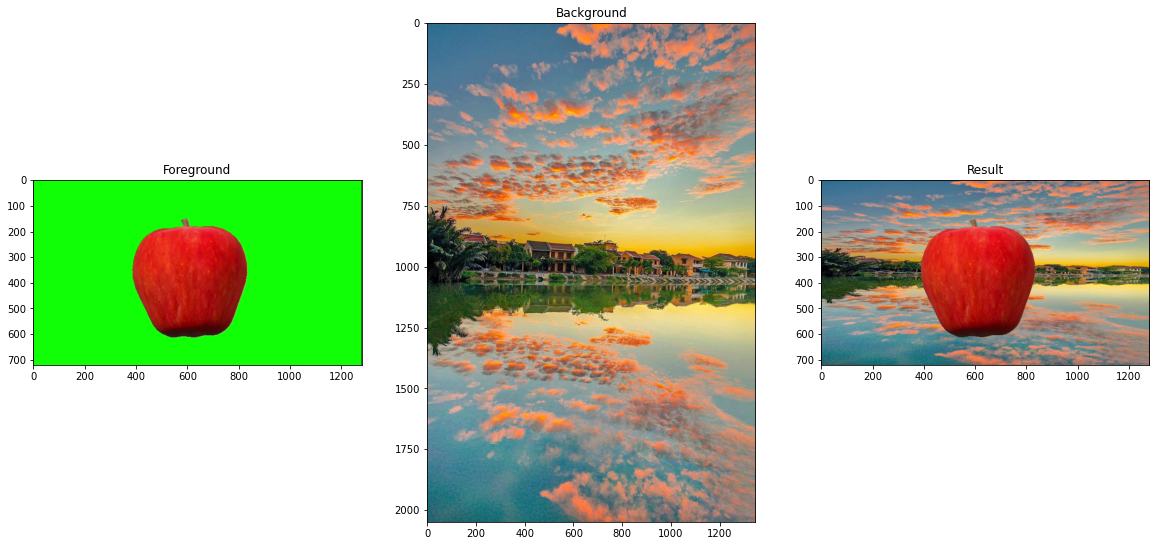

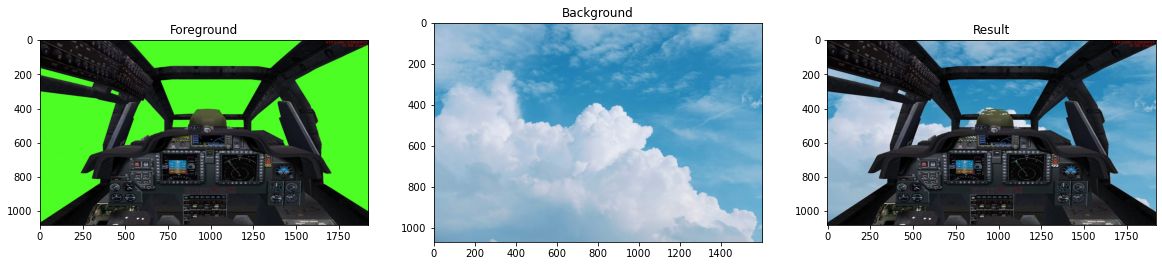

In [18]:
path_folder_fg = './test_data/'
path_folder_bg = './background/'
for i in range(1, 6):
    pathfg = path_folder_fg + str(i) + '.jpg'
    pathbg = path_folder_bg + str(i) + '.jpg'
    fg, bg, newimg = process_image(pathfg, pathbg)
    show_image(fg, bg, newimg)
    #save_image(newimg, 'ouput'+str(i)+'.jpg')


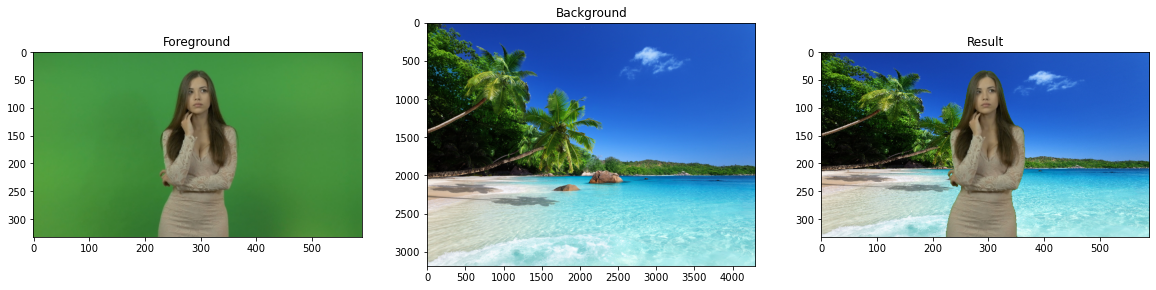

In [19]:
pathimg = './test_data/9.jpg'
pathbg = './background/8.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)


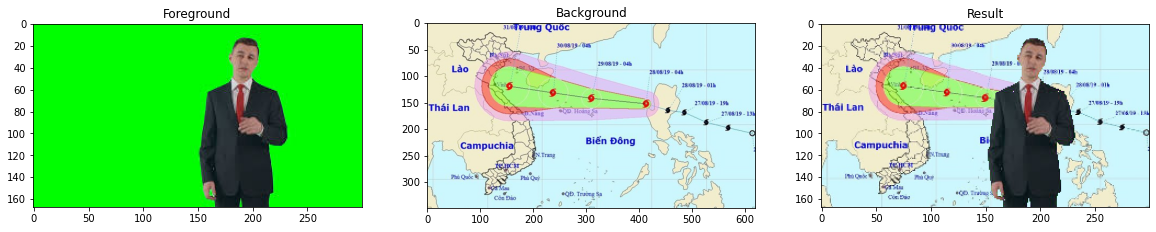

In [20]:
pathimg = './test_data/2.jpg'
pathbg = './background/1.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)

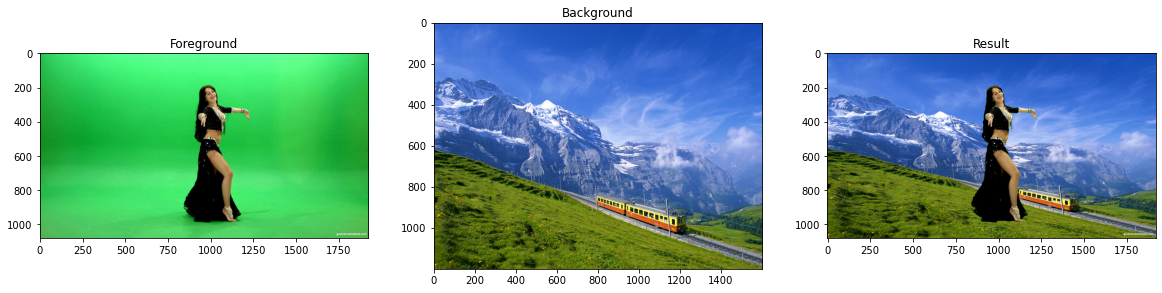

In [21]:
pathimg = './test_data/11.jpg'
pathbg = './background/6.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)
save_image(newimg, 'output8.jpg')

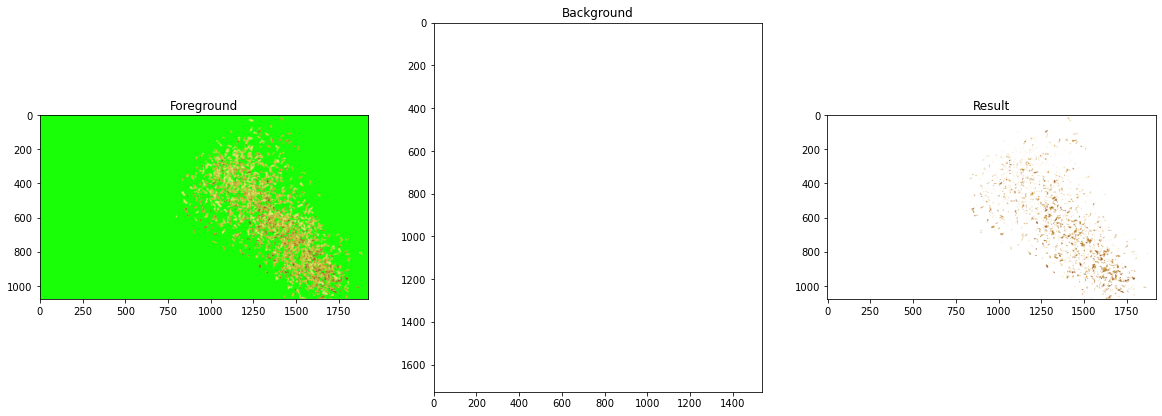

In [22]:
pathimg = './test_data/10.jpg'
pathbg = './background/9.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)

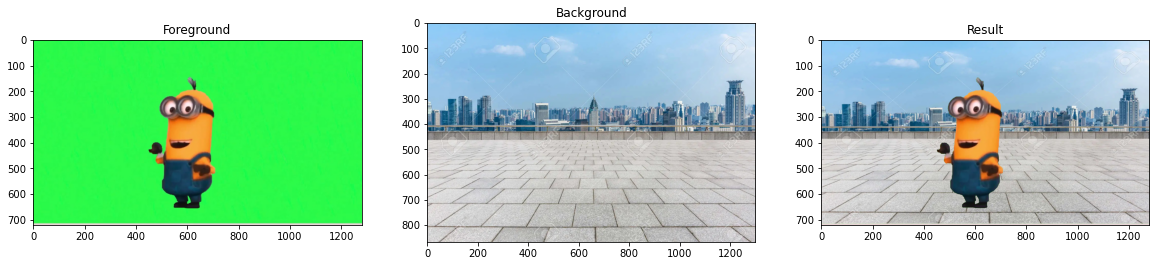

In [23]:
pathimg = './test_data/28.jpg'
pathbg = './background/10.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)

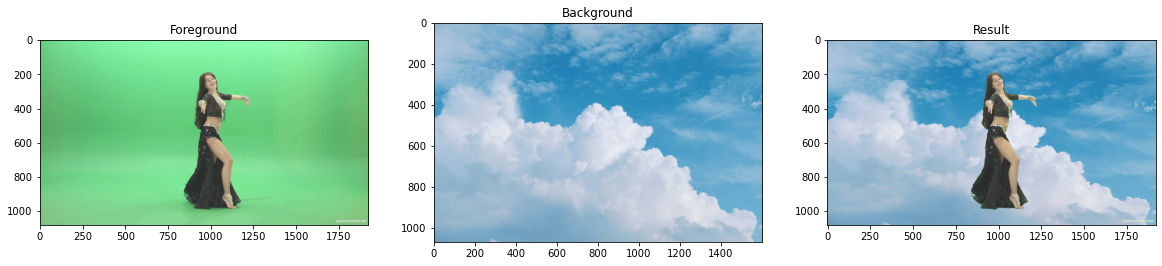

In [24]:
pathimg = './test_data/8.jpg'
pathbg = './background/5.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)
#save_image(newimg, 'output_anhtoi.jpg')

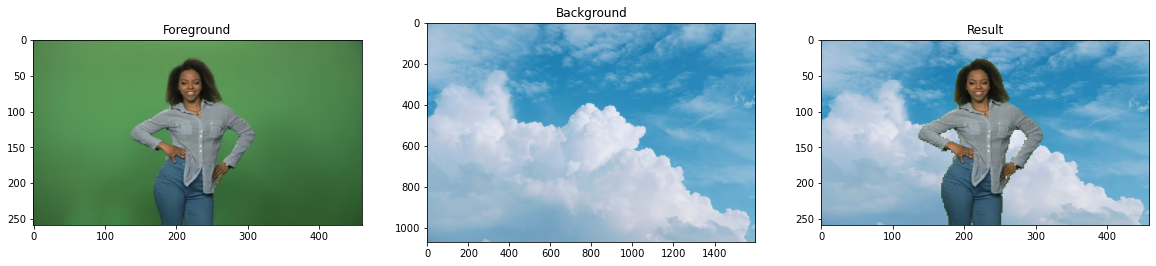

In [27]:
pathimg = './test_data/12.jpg'
pathbg = './background/5.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)

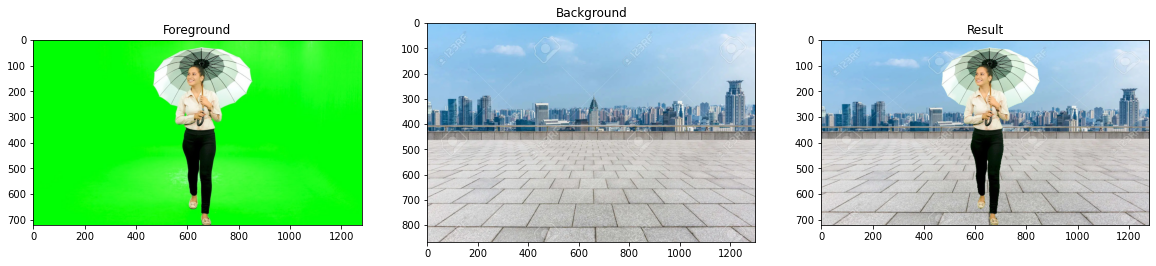

In [29]:
pathimg = './test_data/20.jpg'
pathbg = './background/10.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)
save_image(newimg, 'output11.jpg')

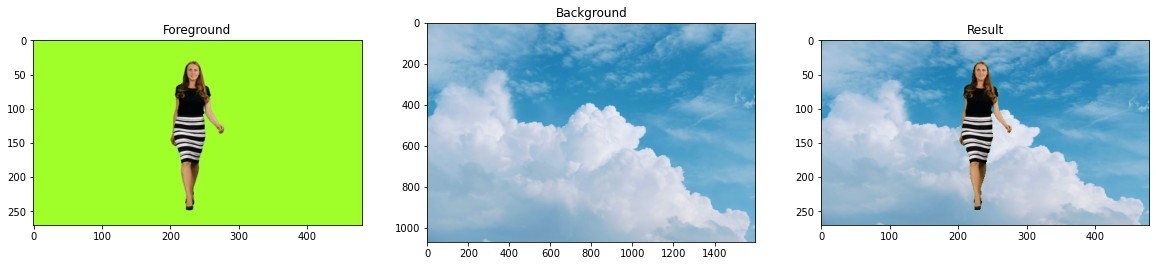

In [30]:
pathimg = './test_data/13.jpg'
pathbg = './background/5.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)
#save_image(newimg, 'output12.jpg')

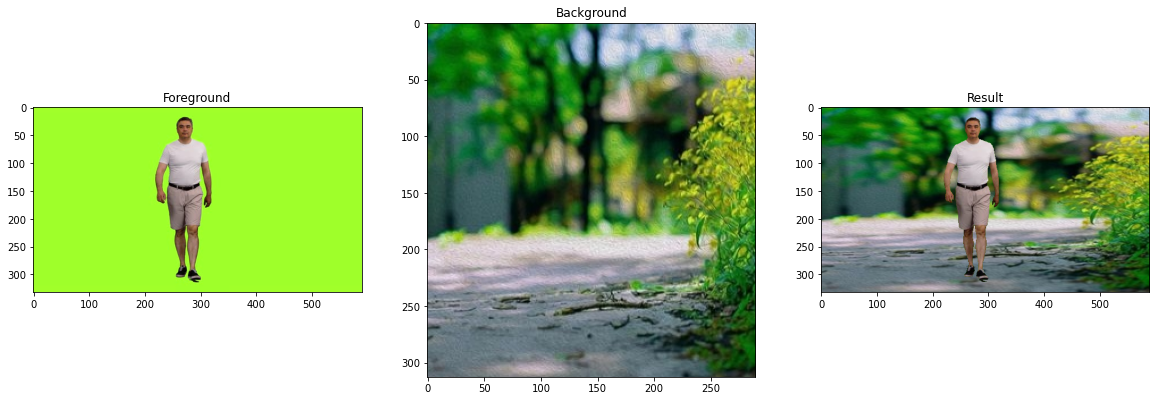

In [31]:
pathimg = './test_data/14.jpg'
pathbg = './background/3.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)
#save_image(newimg, 'output13.jpg')

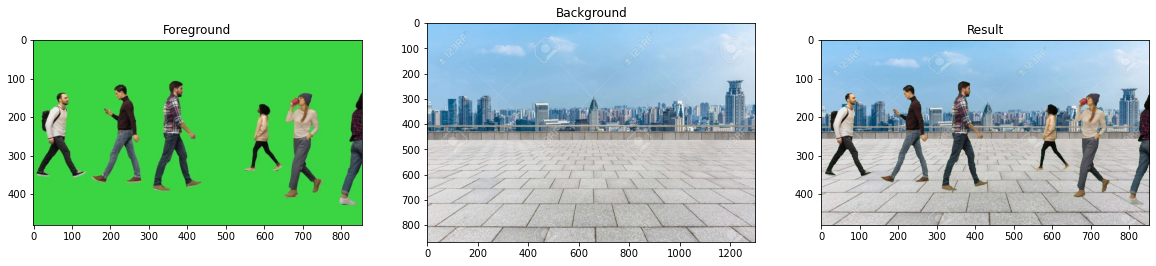

In [32]:
pathimg = './test_data/15.jpg'
pathbg = './background/10.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)
#save_image(newimg, 'output14.jpg')

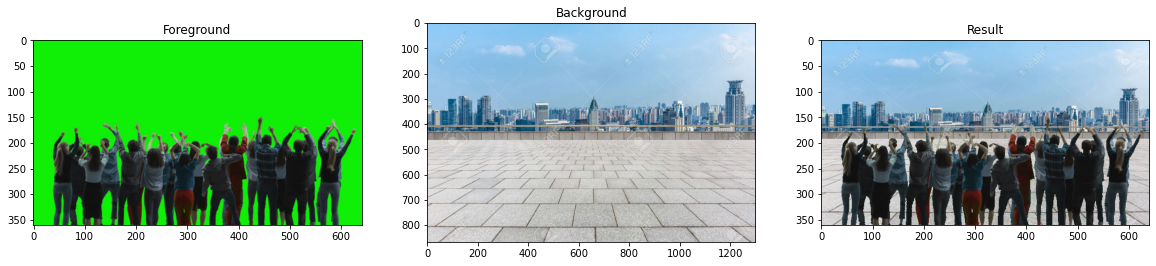

In [33]:
pathimg = './test_data/16.jpg'
pathbg = './background/10.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)
#save_image(newimg, 'output15.jpg')

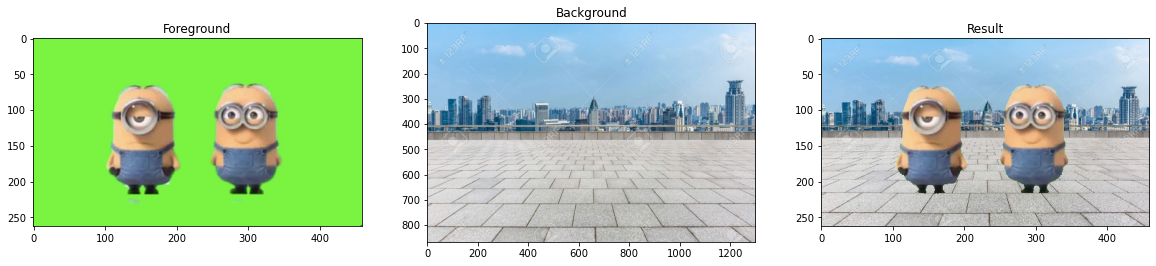

In [34]:
pathimg = './test_data/17.jpg'
pathbg = './background/10.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)

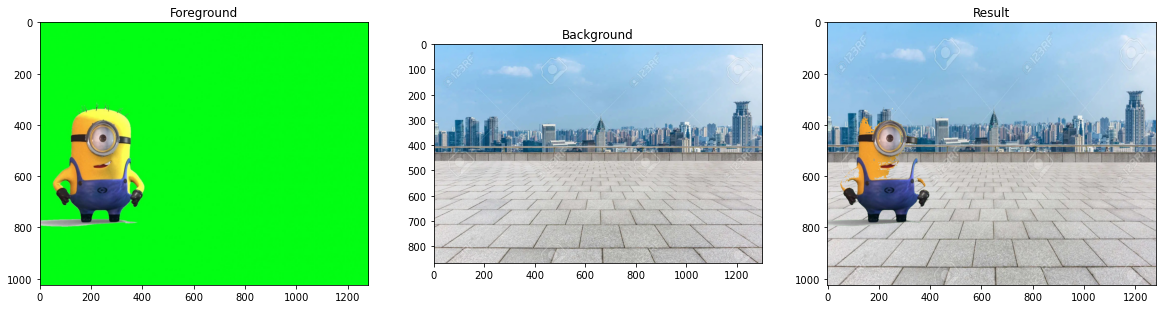

In [35]:
pathimg = './test_data/18.jpg'
pathbg = './background/10.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)
save_image(newimg, 'output16.jpg')

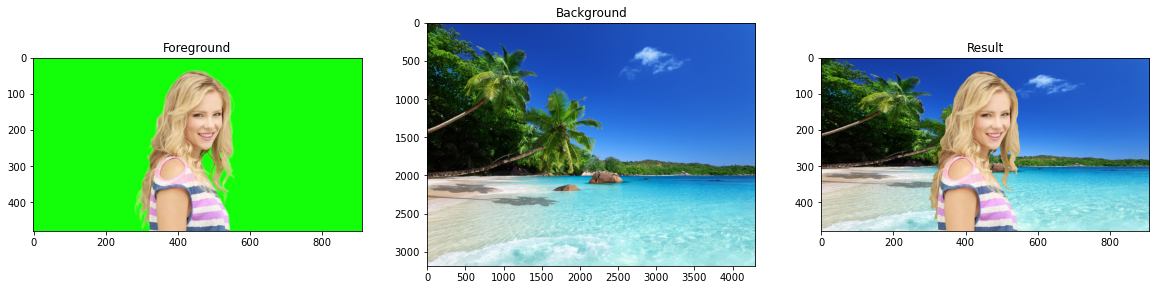

In [36]:
pathimg = './test_data/24.jpg'
pathbg = './background/8.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)
save_image(newimg, 'output17.jpg')

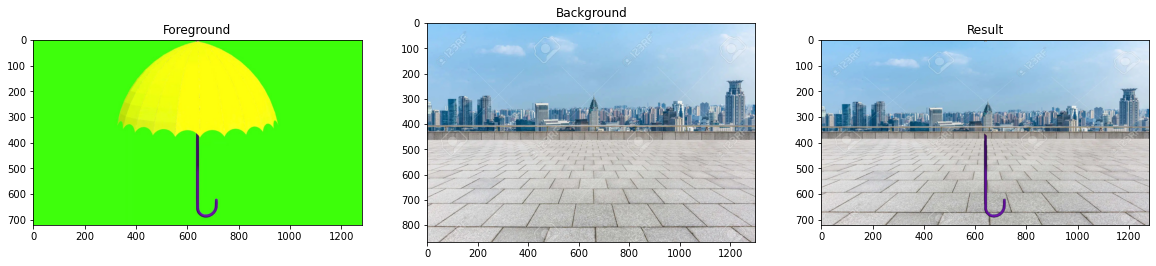

In [37]:
pathimg = './test_data/25.jpg'
pathbg = './background/10.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)

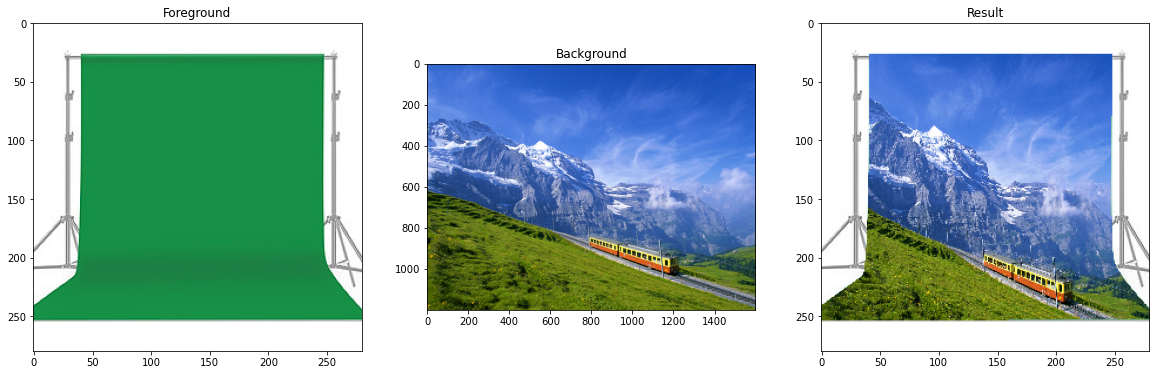

In [38]:
pathimg = './test_data/6.jpg'
pathbg = './background/6.jpg'
fg, bg, newimg = process_image(pathimg, pathbg)
show_image(fg, bg, newimg)

In [35]:
pathvideo = './video/video2.mp4'
bg = read_img('./background/8.jpg')
process_video(pathvideo, bg)